In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

In [27]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)

import yaml

with open(Path.cwd().parent / 'data' / 'interconnection_helpers.yaml', 'r') as f:
    inter_bmu = yaml.safe_load(f)['interconnection_mapper']

intercon_lats = []

for i, (key, item) in enumerate(inter_bmu.items()):

    if key == 'Nemo':
        intercon_lats.append(0)
        continue

    lat = bmus.loc[bmus.index.str.startswith(item[0]+'-'), 'lat'].dropna().astype(float).mean()
    intercon_lats.append(lat)

intercon_lats = pd.Series(intercon_lats, index=inter_bmu.keys())

intercon_lats.loc['EastWest'] = 53.23
intercon_lats.loc['Moyle'] = 55.07
intercon_lats.loc['Nemo'] = 51.297

intercon_lats = intercon_lats.to_frame().rename(columns={0: 'lat'})

In [28]:
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0
)
bmus = bmus.loc[bmus['bus'] != 'distributed']

bmus.loc[:,'lat'] = bmus['lat'].astype(float)
bmus.loc[:,'lon'] = bmus['lon'].astype(float)

bmus = bmus[['lon', 'lat']]

In [29]:
bmus

,lon,lat
NationalGridBmUnit,,
IBG-EGEN1,0.653,51.46
IBG-ENGI1,0.653,51.46
IBG-RSQ1,0.653,51.46
IVD-VKL1,-0.221,52.931
IVG-VKL1,-0.221,52.931
...,...,...
GRGBW-2,1.713867,52.066
GRGBW-3,1.713867,52.066
SGRWO-1,-1.741,56.588


In [30]:
z = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_zonal.csv'
n = Path.cwd().parent / 'summaries' / 'total_unit_revenues_flex_national.csv'

z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
n = pd.read_csv(n, parse_dates=True, index_col=[0,1])

n_total = n.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)
z_total = z.replace(np.nan, 0).groupby(level=0).sum().sum(axis=1)

n_total = n_total[n_total > 0]
zonal_total = z_total.loc[n_total.index]

diff = (zonal_total - n_total).clip(lower=-1, upper=1)

# diff = pd.concat([diff.to_frame(), bmus.loc[diff.index, ['lon', 'lat']]], axis=1)

C:\Users\lukas\AppData\Local\Temp\ipykernel_40044\2293050130.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_40044\2293050130.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  z = pd.read_csv(z, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_40044\2293050130.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  n = pd.read_csv(n, parse_dates=True, index_col=[0,1])
C:\Users\lukas\AppData\Local\Temp\ipykernel_40044\2293050130.py:5: UserWarning:

In [31]:
bmus

,lon,lat
NationalGridBmUnit,,
IBG-EGEN1,0.653,51.46
IBG-ENGI1,0.653,51.46
IBG-RSQ1,0.653,51.46
IVD-VKL1,-0.221,52.931
IVG-VKL1,-0.221,52.931
...,...,...
GRGBW-2,1.713867,52.066
GRGBW-3,1.713867,52.066
SGRWO-1,-1.741,56.588


In [22]:
intersec = bmus.index.intersection(diff.index)

gseries = gpd.GeoDataFrame(
    diff.loc[intersec],
    geometry=gpd.points_from_xy(
        bmus.loc[intersec, 'lon'],
        bmus.loc[intersec, 'lat']
        )
    ).rename(columns={0: 'diff'})

In [24]:
gseries

,diff,geometry
BFSE01,1.0,POINT (-1.22 52.585)
AG-HLIM01,1.0,POINT (-1.494 51.598)
AG-HLIM02,1.0,POINT (-1.194 50.852)
AG-HLIM03,1.0,POINT (-1.99 51.616)
AG-HLIM04,1.0,POINT (-1.494 51.598)
...,...,...
GRGBW-2,1.0,POINT (1.71387 52.066)
GRGBW-3,1.0,POINT (1.71387 52.066)
SGRWO-1,-1.0,POINT (-1.741 56.588)
ABRBO-1,-1.0,POINT (-1.98333 57.2167)


In [12]:
regions = gpd.read_file(
    Path.cwd().parent / 'data' / 'gb_shape.geojson'
).set_index('name')

In [18]:
gseries

,diff,geometry
BFSE01,1.0,POINT (-1.22 52.585)
AG-HLIM01,1.0,POINT (-1.494 51.598)
AG-HLIM02,1.0,POINT (-1.194 50.852)
AG-HLIM03,1.0,POINT (-1.99 51.616)
AG-HLIM04,1.0,POINT (-1.494 51.598)
...,...,...
GRGBW-2,1.0,POINT (1.71387 52.066)
GRGBW-3,1.0,POINT (1.71387 52.066)
SGRWO-1,-1.0,POINT (-1.741 56.588)
ABRBO-1,-1.0,POINT (-1.98333 57.2167)


In [20]:
def classify_north_south(lon, lat):
    """Splits GB into north and south, where north represents regions 
    with diminished wholesale market prices"""

    lon = float(lon)
    lat = float(lat)

    m = 0.55
    b = 56.4

    if lat > m * lon + b:
        return 'north'
    else:
        return 'south'


In [21]:
gseries['region']


,diff,geometry
BFSE01,1.0,POINT (-1.22 52.585)
AG-HLIM01,1.0,POINT (-1.494 51.598)
AG-HLIM02,1.0,POINT (-1.194 50.852)
AG-HLIM03,1.0,POINT (-1.99 51.616)
AG-HLIM04,1.0,POINT (-1.494 51.598)
...,...,...
GRGBW-2,1.0,POINT (1.71387 52.066)
GRGBW-3,1.0,POINT (1.71387 52.066)
SGRWO-1,-1.0,POINT (-1.741 56.588)
ABRBO-1,-1.0,POINT (-1.98333 57.2167)


In [33]:
bmus['region'] = bmus.apply(lambda x: classify_north_south(x['lon'], x['lat']), axis=1)
gdf = gpd.GeoDataFrame(bmus, geometry=gpd.points_from_xy(bmus['lon'], bmus['lat']))

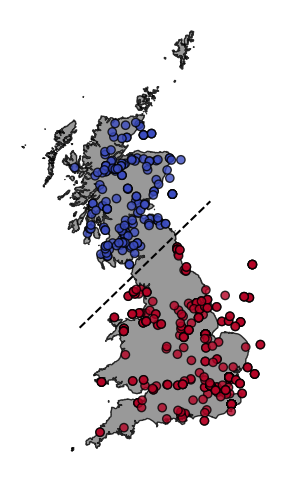

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))

# gseries.plot(ax=ax, column='diff', cmap='coolwarm')
gdf.plot(ax=ax, column='region', cmap='coolwarm', edgecolor='k', alpha=0.8)
regions.plot(ax=ax, facecolor='grey', zorder=0, alpha=0.8, edgecolor='k')


tangent_x = np.linspace(-6, 0, 2)
tangent_y = 0.55 * tangent_x + 56.4

ax.plot(tangent_x, tangent_y, 'k--', label='Tangent')

ax.set_axis_off()

plt.savefig('north_south_split.pdf')
plt.show()